# Plot Probability Curves

In [5]:
import cv2
import imageio
import torch
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_atari_env
from collections import deque

In [2]:
def class_probabilities(dist: float, obs_dim: int, std: float = 0.3) -> list:
    """Calculate probabilities for moving up and down."""

    # Normalize x to the range [0, 1]
    dist_normalized = (dist + obs_dim) / (obs_dim * 2)

    # Calculate probabilities using a smooth transition
    prob_up = np.exp(-((dist_normalized - 0) ** 2) / (2 * (std ** 2)))
    prob_down = np.exp(-((dist_normalized - 1) ** 2) / (2 * (std ** 2)))

    # Normalize the probabilities so that they sum to 1
    prob_sum = prob_up + prob_down
    prob_up /= prob_sum
    prob_down /= prob_sum

    return [prob_up, prob_down]

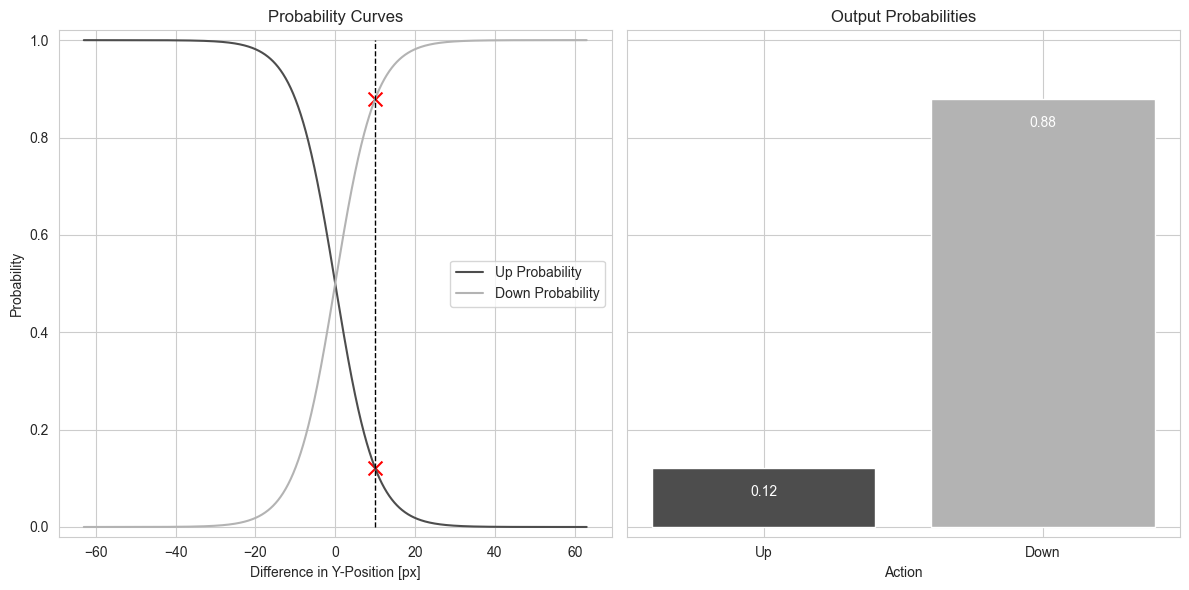

In [10]:
field_height = 63
sigma = 0.2
selection = 10

# Generate x values from -80 to 80
x_values = np.linspace(-field_height, field_height, 1000)

# Calculate probabilities for each x value
probabilities = np.array([class_probabilities(x, field_height, sigma) for x in x_values])
prob_0, prob_1 = class_probabilities(selection, field_height, sigma)

# Plot the probability curves
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
ax[0].plot(x_values, probabilities[:, 0], label='Up Probability', color='.3')
ax[0].plot(x_values, probabilities[:, 1], label='Down Probability', color='.7')
ax[0].vlines(selection, 0, 1, colors="black", linestyles="dashed", lw=1)
ax[0].scatter(selection, prob_0, c="red", marker="x", s=100)
ax[0].scatter(selection, prob_1, c="red", marker="x", s=100)
# Plot vertical bar plot
ax[1].bar(["Up", "Down"], [prob_0, prob_1], color=[".3", ".7"])
ax[1].text(0, prob_0 - 0.05, f"{prob_0:.2f}", ha='center', va='center', color='white')
ax[1].text(1, prob_1 - 0.05, f"{prob_1:.2f}", ha='center', va='center', color='white')
# Add labels and legend
ax[0].set_ylim(-0.02, 1.02)
ax[0].set_xlabel('Difference in Y-Position [px]')
ax[1].set_xlabel('Action')
ax[0].set_ylabel('Probability')
ax[0].set_title('Probability Curves')
ax[1].set_title('Output Probabilities')
ax[0].legend()
plt.tight_layout()
plt.show()

# Record GIF

In [2]:
env = make_atari_env(env_id="PongNoFrameskip-v4", n_envs=1, seed=1)

In [3]:
# Initialize new random model or load a pre-trained model
model = PPO(
    "CnnPolicy",
    env,
    tensorboard_log=None,
    policy_kwargs=dict(features_extractor_kwargs={"features_dim": 512}),
    device="cpu",
    seed=1,
)

# model = PPO.load("ppo_nature_cnn_pretrained.zip", env=env, device="cpu")

In [ ]:
# Define parameters
n_frames = 300
output_file = "pretrained_actions.gif"
use_random_actions = False

# Initialize
value_buffer = deque(maxlen=n_frames)
frames = []
np_obs = env.reset()

# Record the frames
for _ in range(n_frames):
    # Adjust observation shape and normalize
    obs = torch.tensor(np_obs).permute(0, 3, 1, 2).float() / 255
    # Get the predicted action probabilities and value
    with torch.no_grad():
        hidden = model.policy.features_extractor(obs)
        action_dist = model.policy.action_net(hidden)
        value = model.policy.value_net(hidden).item()
    # Store the predicted value
    value_buffer.append(value)
    # Calculate action probabilities
    probas = action_dist.softmax(dim=-1)
    reduced_probas = (probas[:, [0, 2, 3]] + probas[:, [1, 4, 5]]).squeeze(0)
    # Select the action with the highest probability
    action = probas.argmax(dim=-1).numpy()
    # If random actions are used, sample a random action
    if use_random_actions:
        action = np.array([env.action_space.sample()])
    # Perform the action and step the environment
    np_obs, reward, done, info = env.step(action)
    
    # Plot the observation, predicted action probabilities, and predicted value
    fig = plt.figure(figsize=(10, 8))
    gs = fig.add_gridspec(2, 2, height_ratios=[5/3, 1])
    
    ax0 = fig.add_subplot(gs[0, 0])  # First row
    ax1 = fig.add_subplot(gs[0, 1])  # First row
    ax2 = fig.add_subplot(gs[1, :])  # Second row, spanning both columns
    
    # Plot the observation
    ax0.imshow(np_obs[0, :, :, 0], cmap="gray")
    ax0.set_title("Observation", fontdict={"fontweight": "bold"})
    ax0.set_xlabel("Image Width")
    ax0.set_ylabel("Image Height")
    ax0.grid(False)
    
    # Plot the predicted action probabilities
    ax1.bar(range(3), reduced_probas, color="dimgray")
    ax1.set_title("Predicted Action Probabilities", fontdict={"fontweight": "bold"})
    ax1.set_xlabel("Actions")
    ax1.set_ylabel("Probability")
    ax1.set_xticks(range(3))
    ax1.set_xticklabels(["NOOP", "UP", "DOWN"], rotation=0, ha="center")
    ax1.set_ylim(0, 1)
    ax1.grid(False)
    
    # Plot the predicted value
    ax2.plot(value_buffer, color="dimgray")
    ax2.set_title("Predicted Value", fontdict={"fontweight": "bold"})
    ax2.set_xlabel("Time Steps")
    ax2.set_ylabel("Value")
    ax2.set_xlim(0, n_frames)
    ax2.set_ylim(-1.25, 1.25)
    ax2.grid(False)
    
    plt.tight_layout()
    
    # Save the current frame to the list
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.buffer_rgba(), dtype="uint8")
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    frames.append(frame)
    plt.close(fig)
    
# Save the frames as a GIF
imageio.mimsave(output_file, frames, fps=10, subrectangles=True, loop=0)

# Record Video

In [22]:
env = make_atari_env(env_id="PongNoFrameskip-v4", n_envs=1, seed=1)

In [23]:
# Initialize new random model or load a pre-trained model
model = PPO(
    "CnnPolicy",
    env,
    tensorboard_log=None,
    policy_kwargs=dict(features_extractor_kwargs={"features_dim": 512}),
    device="cpu",
    seed=1,
)

# model = PPO.load("ppo_nature_cnn_finetuned.zip", env=env, device="cpu")

In [24]:
n_frames = 500
output_file = "model_playing.gif"

images = []
obs = model.env.reset()
img = model.env.render(mode="rgb_array")

for i in range(n_frames):
    images.append(img)
    action, _ = model.predict(obs)
    obs, _, _ ,_ = model.env.step(action)
    img = model.env.render(mode="rgb_array")

imageio.mimsave(output_file, [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=10, subrectangles=True, loop=0)